In [536]:
from datetime import date
from os import mkdir, listdir, remove
from os.path import join
import requests
from zipfile import ZipFile
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

In [104]:
filenames = []
months = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', \
          'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']
base_url = 'https://www.camara.leg.br/internet/plenario/result/votacao/'

for year in range(2019, 2023):
    for month in range(1, 13):
        if date(year, month, 1) < date.today():
            d = date(year, month, 1)
            y = str(d.year)[-2:]
            m = months[int(d.month) - 1]
            filenames.append(m + y + '.zip')
            
del dates[-1]
urls = [base_url + filename for filename in filenames]

In [105]:
try: 
    mkdir('files')
except: 
    pass

for filename, url in zip(filenames, urls):
    with open(join('files', filename), 'wb') as file:
        file.write(requests.get(url).content)

In [106]:
files = listdir('files')

for filename in files:
    try:
        f = ZipFile(join('files', filename))
        f.extractall('files')
    except:
        print(f'not valid: {filename}', end = ', ')

not valid: abril19.zip, not valid: abril20.zip, not valid: agosto19.zip, not valid: agosto20.zip, not valid: dezembro19.zip, not valid: dezembro20.zip, not valid: fevereiro19.zip, not valid: fevereiro20.zip, not valid: janeiro19.zip, not valid: janeiro20.zip, not valid: janeiro21.zip, not valid: julho19.zip, not valid: julho20.zip, not valid: junho19.zip, not valid: junho20.zip, not valid: maio19.zip, not valid: maio20.zip, not valid: marco19.zip, not valid: marco20.zip, not valid: marco21.zip, not valid: novembro19.zip, not valid: novembro20.zip, not valid: outubro19.zip, not valid: outubro20.zip, not valid: setembro19.zip, not valid: setembro20.zip, 

In [171]:
votings = [file for file in listdir('files') if re.fullmatch('LV\w{15}.(txt)|(TXT)', file)]
votes = []

for voting in votings:
    with open(join('files', voting)) as file:
        for line in file:
            session = line[0:9].rstrip(' ')
            voting = line[10:16].rstrip(' ')
            name = line[17:56].rstrip(' ')
            vote = line[57:66].rstrip(' ')
            party = line[67:76].rstrip(' ')
            state = line[77:101].rstrip(' ')
            id = line[102:-1].rstrip(' ')
            votes.append((session, voting, name, vote, party, state, id))

In [385]:
df = pd.DataFrame(votes, columns = ['session', 'voting', 'name', 'vote', 'party', 'state', 'id'])

In [386]:
df

,session,voting,name,vote,party,state,id
0,CC03O007E,009470,JHONATAN DE JESUS,Sim,Republica,Roraima,5
1,CC03O007E,009470,JOENIA WAPICHANA,Sim,Rede,Roraima,3
2,CC03O007E,009470,NICOLETTI,Sim,PSL,Roraima,6
3,CC03O007E,009470,OTTACI NASCIMENTO,Sim,Solidarie,Roraima,7
4,CC03O007E,009470,ACÁCIO FAVACHO,Sim,PROS,Amapá,10
...,...,...,...,...,...,...,...
94861,CD03O059E,009735,PAULO PEREIRA DA SILVA,<------->,Solidarie,São Paulo,372
94862,CD03O059E,009735,ROBERTO DE LUCENA,<------->,Podemos,São Paulo,385
94863,CD03O059E,009735,KIM KATAGUIRI,<------->,DEM,São Paulo,366
94864,CD03O059E,009735,GILBERTO NASCIMENTO,<------->,PSC,São Paulo,360


In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94866 entries, 0 to 94865
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  94866 non-null  object
 1   voting   94866 non-null  object
 2   name     94866 non-null  object
 3   vote     94866 non-null  object
 4   party    94866 non-null  object
 5   state    94866 non-null  object
 6   id       94866 non-null  object
dtypes: object(7)
memory usage: 5.1+ MB


In [388]:
df.describe()

,session,voting,name,vote,party,state,id
count,94866,94866,94866,94866,94866,94866,94866
unique,29,181,522,7,24,27,522
top,CD03O054E,009472,BACELAR,Não,PSL,São Paulo,201
freq,13338,1024,185,39288,9805,12950,185


In [389]:
df.party.unique()

array(['Republica', 'Rede', 'PSL', 'Solidarie', 'PROS', 'PP', 'PSB',
       'Avante', 'PCdoB', 'PL', 'PT', 'PSD', 'MDB', 'DEM', 'PTB', 'PSOL',
       'Podemos', 'PDT', 'PSDB', 'PSC', 'PV', 'Patriota', 'Novo',
       'Cidadania'], dtype=object)

In [390]:
df.vote.unique()

array(['Sim', 'Não', '<------->', 'Abstenção', 'Art.51', 'Art. 17',
       'Obstrução'], dtype=object)

In [391]:
df.loc[df.vote == 'Art. 17']

,session,voting,name,vote,party,state,id
5764,CD03O031E,009436,ARTHUR LIRA,Art. 17,PP,Alagoas,162
6271,CD03O031E,009437,ARTHUR LIRA,Art. 17,PP,Alagoas,162
6782,CD03O031E,009438,ARTHUR LIRA,Art. 17,PP,Alagoas,162
7206,CD03O031E,009439,MARCELO RAMOS,Art. 17,PL,Amazonas,42
7308,CD03O031E,009439,ARTHUR LIRA,Art. 17,PP,Alagoas,162
...,...,...,...,...,...,...,...
92441,CD03O059E,009729,ARTHUR LIRA,Art. 17,PP,Alagoas,162
92944,CD03O059E,009731,ARTHUR LIRA,Art. 17,PP,Alagoas,162
93466,CD03O059E,009732,ARTHUR LIRA,Art. 17,PP,Alagoas,162
93976,CD03O059E,009733,ARTHUR LIRA,Art. 17,PP,Alagoas,162


In [392]:
totals_per_voter = (df.value_counts(subset=['name', 'vote']).
                    reset_index().
                    pivot(index='name',columns='vote',values=0).
                    fillna(0).
                    astype('int'))

#totals_per_voter.columns = totals_per_voter.columns.droplevel()

totals_per_voter

vote,<------->,Abstenção,Art. 17,Art.51,Não,Obstrução,Sim
name,,,,,,,
ABOU ANNI,20,0,0,0,89,0,76
ABÍLIO SANTANA,48,0,0,0,73,2,62
ACÁCIO FAVACHO,22,0,0,0,88,0,75
ADOLFO VIANA,51,0,0,0,73,1,60
ADRIANA VENTURA,4,0,0,0,84,13,84
...,...,...,...,...,...,...,...
ZÉ SILVA,31,0,0,0,78,1,75
ZÉ VITOR,42,0,0,0,74,2,67
ÁTILA LINS,28,0,0,0,84,0,73


In [393]:
totals_per_voter[['Sim', 'Não']].eval('Total = Sim + Não').describe()

vote,Sim,Não,Total
count,522.000000,522.000000,522.000000
mean,69.130268,75.264368,144.394636
std,16.551156,18.460599,32.233395
min,0.000000,0.000000,0.000000
25%,62.250000,66.000000,133.000000
50%,72.000000,78.000000,151.000000
75%,80.000000,89.000000,166.000000
max,112.000000,105.000000,185.000000


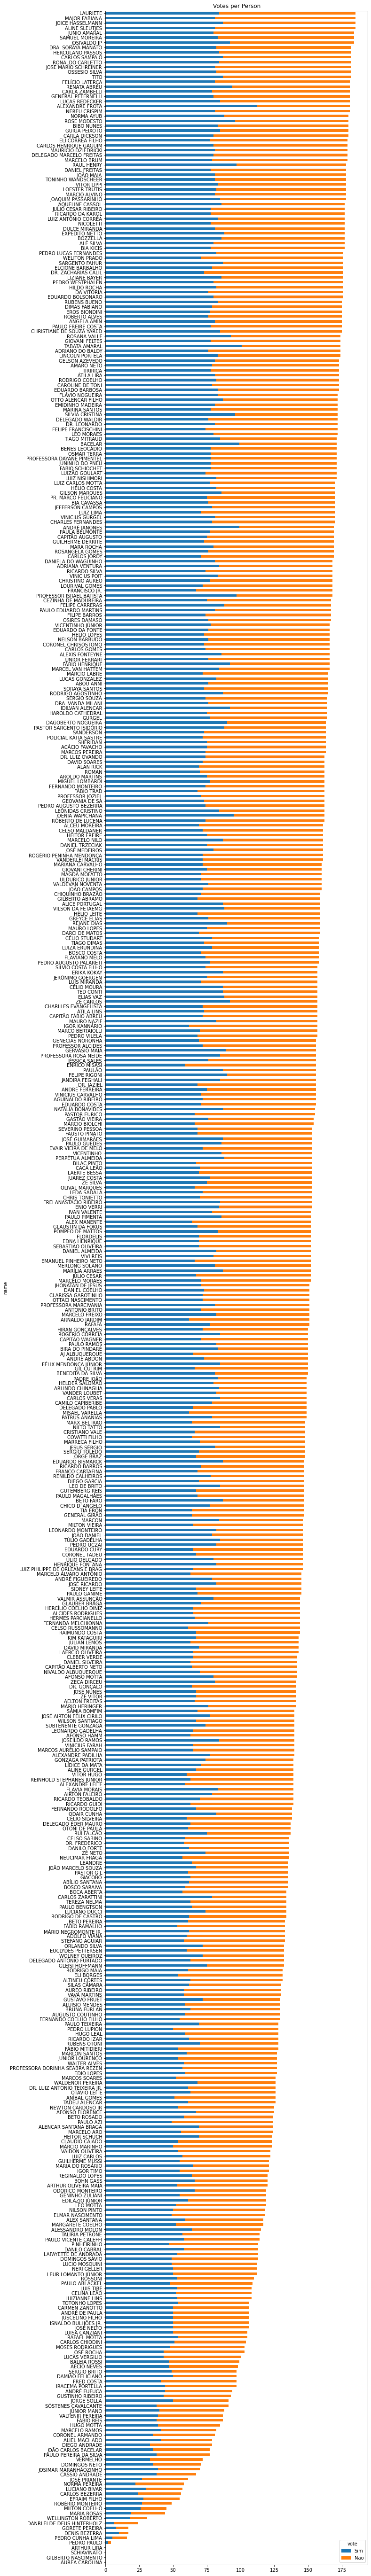

In [394]:
(totals_per_voter[['Sim', 'Não']].
 eval('Total = Sim + Não').
 sort_values(by='Total').
 drop(columns='Total').
 plot.barh(stacked=True, figsize=(10,100), title = 'Votes per Person'));

<AxesSubplot:xlabel='name'>

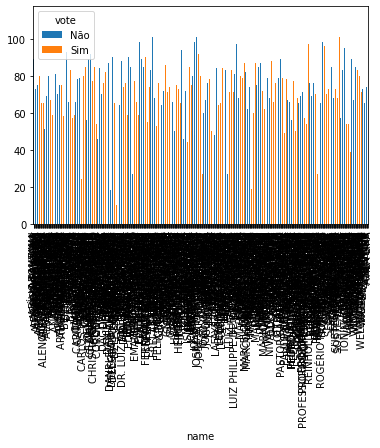

In [395]:
(df.loc[(df.vote == 'Sim') | (df.vote == 'Não')].
 value_counts(subset=['name', 'vote']).
 reset_index().
 pivot(index='name',columns='vote',values=0).
 fillna(0).
 astype('int')).plot(kind='bar')

In [396]:
(df.
 loc[(df.vote == 'Sim') | (df.vote == 'Não')].
 eval("vote = vote == 'Sim'")
 [['voting', 'id', 'vote']].
 astype({'voting':'str', 'id':'str', 'vote':'int'}).
 value_counts(['voting', 'id']))

voting  id 
009470  404    2
009472  363    2
        361    2
        359    2
        358    2
              ..
009578  315    1
        316    1
        317    1
        318    1
009735  98     1
Length: 73803, dtype: int64

In [397]:
df.loc[(df.voting == '009470') & (df.id == '404')]

,session,voting,name,vote,party,state,id
290,CC03O007E,009470,JOSÉ MEDEIROS,Sim,Podemos,Mato Grosso,404
2338,CC03O008E,009470,JOSÉ MEDEIROS,Sim,Podemos,Mato Grosso,404


In [555]:
votes_by_person = (df.
                  loc[(df.vote == 'Sim') | (df.vote == 'Não')].
                  assign(voting_id = df.session + ' ' + df.voting)
                  [['voting_id', 'name', 'vote']].
                  pivot(index = 'name', columns = 'voting_id', values = 'vote').
                  applymap(lambda vote : 1 if vote=='Sim' else -1, na_action='ignore').
                  fillna(value=0).
                  astype('int'))

In [441]:
distances = cosine_distances(votes_by_person.values)

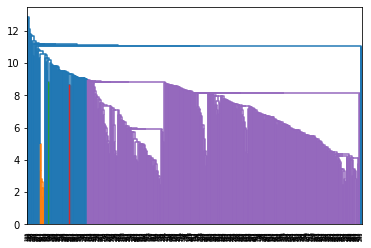

In [460]:
dendrogram(linkage(votes_by_person.values));

In [556]:
votes_by_person

voting_id,CC03O007E 009470,CC03O007E 009471,CC03O007E 009472,CC03O007E 009473,CC03O008E 009470,CC03O008E 009471,CC03O008E 009472,CC03O008E 009473,CC03O011E 009714,CC03O011E 009715,...,CD03O059E 009724,CD03O059E 009725,CD03O059E 009726,CD03O059E 009727,CD03O059E 009728,CD03O059E 009729,CD03O059E 009731,CD03O059E 009732,CD03O059E 009733,CD03O059E 009735
name,,,,,,,,,,,,,,,,,,,,,
ABOU ANNI,1,-1,1,-1,1,-1,1,-1,1,-1,...,-1,0,-1,-1,1,1,1,1,1,-1
ABÍLIO SANTANA,1,0,1,-1,1,0,1,-1,0,0,...,-1,-1,-1,-1,1,1,1,1,1,-1
ACÁCIO FAVACHO,1,-1,1,-1,1,-1,1,-1,1,-1,...,-1,-1,-1,-1,1,1,1,1,1,0
ADOLFO VIANA,0,0,0,0,0,0,0,0,0,-1,...,-1,-1,-1,-1,-1,1,1,1,1,-1
ADRIANA VENTURA,1,1,1,1,1,1,1,1,1,1,...,-1,1,1,1,1,1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZÉ NETO,0,-1,1,-1,0,-1,1,-1,-1,-1,...,1,1,1,1,1,0,1,-1,-1,0
ZÉ SILVA,1,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,1,1,1,-1,1,-1
ZÉ VITOR,0,0,0,-1,0,0,0,-1,1,0,...,-1,-1,-1,-1,1,1,1,-1,1,0


In [557]:
votes_by_person.to_csv('votes_by_person_vectors.tsv', sep = '\t', header=False, index=False)

In [612]:
voters = df[['name', 'party', 'state', 'id']].drop_duplicates()

In [634]:
(votes_by_person.
 index.
 to_frame().
 reset_index(drop = True).
 join(other = voters.set_index('name'), on = 'name').
 to_csv('votes_by_person_metadata.tsv', sep = '\t', header = True, index = False))

### Hierarchichal clustering per party

In [498]:
votes_by_party = (df.
                  assign(voting_id = df.session + ' ' + df.voting).
                  loc[(df.vote == 'Sim') | (df.vote == 'Não')].
                  eval('vote = vote == "Sim"')
                  [['voting_id', 'party', 'vote']].
                  groupby(['voting_id', 'party']).
                  agg('mean').
                  reset_index().
                  pivot(index = 'party', columns = 'voting_id', values = 'vote').
                  fillna(.5))

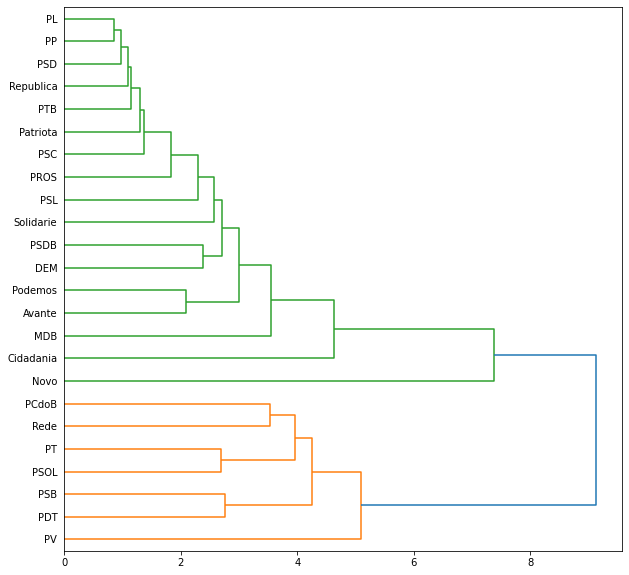

In [535]:
plt.figure(figsize = (10, 10))
link = linkage(votes_by_party.values, metric = 'euclidean', method = 'average', optimal_ordering = True)
dendrogram(link, orientation = 'right', distance_sort = True, labels = votes_by_party.index, color_threshold = 8);

In [487]:
votes_by_party.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, CC03O007E 009470 to CD03O059E 009735
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Avante     185 non-null    float64
 1   Cidadania  181 non-null    float64
 2   DEM        185 non-null    float64
 3   MDB        185 non-null    float64
 4   Novo       174 non-null    float64
 5   PCdoB      165 non-null    float64
 6   PDT        185 non-null    float64
 7   PL         185 non-null    float64
 8   PP         185 non-null    float64
 9   PROS       185 non-null    float64
 10  PSB        185 non-null    float64
 11  PSC        185 non-null    float64
 12  PSD        185 non-null    float64
 13  PSDB       185 non-null    float64
 14  PSL        185 non-null    float64
 15  PSOL       162 non-null    float64
 16  PT         166 non-null    float64
 17  PTB        185 non-null    float64
 18  PV         178 non-null    float64
 19  Patriota   185 non-null    

### Dimensionality reduction per party

In [517]:
votes_by_party

voting_id,CC03O007E 009470,CC03O007E 009471,CC03O007E 009472,CC03O007E 009473,CC03O008E 009470,CC03O008E 009471,CC03O008E 009472,CC03O008E 009473,CC03O011E 009714,CC03O011E 009715,...,CD03O059E 009724,CD03O059E 009725,CD03O059E 009726,CD03O059E 009727,CD03O059E 009728,CD03O059E 009729,CD03O059E 009731,CD03O059E 009732,CD03O059E 009733,CD03O059E 009735
party,,,,,,,,,,,,,,,,,,,,,
Avante,1.000000,0.000000,1.000000,0.166667,1.000000,0.000000,1.000000,0.166667,1.000000,0.000000,...,0.166667,0.125000,0.142857,0.285714,1.000000,0.857143,0.857143,0.857143,0.857143,0.000000
Cidadania,1.000000,0.000000,0.400000,0.666667,1.000000,0.000000,0.400000,0.666667,1.000000,0.000000,...,0.000000,0.500000,0.000000,0.500000,0.166667,0.714286,1.000000,0.857143,0.000000,0.000000
DEM,1.000000,0.047619,1.000000,0.095238,1.000000,0.047619,1.000000,0.095238,1.000000,0.047619,...,0.000000,0.000000,0.000000,0.041667,0.956522,0.950000,0.904762,0.916667,0.894737,0.045455
MDB,1.000000,0.000000,1.000000,0.068966,1.000000,0.000000,1.000000,0.068966,1.000000,0.000000,...,0.000000,0.033333,0.000000,0.000000,1.000000,1.000000,1.000000,0.862069,1.000000,0.000000
Novo,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
PCdoB,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
PDT,1.000000,0.000000,0.954545,0.045455,1.000000,0.000000,0.954545,0.045455,0.950000,0.000000,...,0.826087,0.181818,0.208333,0.045455,0.280000,0.250000,1.000000,0.120000,0.125000,0.000000
PL,0.965517,0.000000,1.000000,0.029412,0.965517,0.000000,1.000000,0.029412,1.000000,0.000000,...,0.055556,0.000000,0.000000,0.000000,0.971429,0.937500,1.000000,0.967742,0.967742,0.000000
PP,1.000000,0.000000,1.000000,0.033333,1.000000,0.000000,1.000000,0.033333,1.000000,0.060606,...,0.000000,0.029412,0.068966,0.033333,0.935484,0.888889,0.970588,1.000000,0.968750,0.062500


In [527]:
votes_by_party.to_csv('votes_by_party_vector.tsv', sep = '\t', header = False, index = False)
votes_by_party.index.to_frame().to_csv('votes_by_party_metadata.tsv', sep = '\t', header = False, index = False)

In [550]:
pca = PCA(n_components = 3)
pca.fit(votes_by_party)
pca.explained_variance_ratio_.sum()

0.8624401818312561

In [553]:
pca.inverse_transform(np.array([1,0,0]))

array([ True, False,  True, False,  True, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### Por estado

### Matriz de correlações entre partidos

# Trash

In [454]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
clustering.fit_predict(votes_wide.values)

array([422, 342, 471, 316, 489, 328, 271, 359, 449, 365, 425, 275, 367,
       343, 368, 270, 491, 287, 398, 428, 445, 293, 303, 304, 513, 263,
       508, 352, 492, 381, 259, 514, 309, 423, 294, 502, 299, 292, 356,
       451, 424, 285, 433, 323, 415, 383, 426, 307, 479, 457, 453, 462,
       245, 463, 341, 384, 170, 417, 351, 325, 438, 289, 279, 421, 337,
       409, 360, 348, 458, 399, 507, 385, 503, 333, 262, 305, 339, 354,
       362, 211, 456, 493, 400, 261, 340, 278, 264, 276, 466, 355, 440,
       306, 308, 439, 363, 347, 390, 212, 370, 210, 280, 288, 427, 312,
       290, 419, 213, 177, 335, 389, 477, 416, 393, 469, 338, 411, 260,
       515, 169, 420, 373, 274, 267, 495, 468, 447, 510, 364, 472, 437,
       143, 361, 313, 353, 388, 379, 490, 291, 455, 494, 480, 374, 324,
       483, 284, 441, 334, 412, 153, 376, 498, 357, 314, 369, 281, 105,
       297, 268, 499, 317, 512, 488, 387, 482, 484, 496, 253, 516, 228,
       301, 283, 176, 207, 311, 327, 302, 322, 346, 446, 497, 24

In [422]:
(df.
 loc[(df.vote == 'Sim') | (df.vote == 'Não')].
 applymap(lambda vote: 1 if vote=='Sim' else -1))

,session,voting,name,vote,party,state,id
0,-1,-1,-1,1,-1,-1,-1
1,-1,-1,-1,1,-1,-1,-1
2,-1,-1,-1,1,-1,-1,-1
3,-1,-1,-1,1,-1,-1,-1
4,-1,-1,-1,1,-1,-1,-1
...,...,...,...,...,...,...,...
94765,-1,-1,-1,-1,-1,-1,-1
94766,-1,-1,-1,-1,-1,-1,-1
94767,-1,-1,-1,-1,-1,-1,-1
94768,-1,-1,-1,-1,-1,-1,-1


In [379]:
df.insert(loc = 0, column = 'voting_id', value = df.session + ' ' + df.voting)

In [383]:
df.drop(columns = ['session', 'voting'], inplace=True)

KeyError: "['session' 'voting'] not found in axis"

In [384]:
df

,voting_id,name,vote,party,state,id
0,CC03O007E 009470,JHONATAN DE JESUS,Sim,Republica,Roraima,5
1,CC03O007E 009470,JOENIA WAPICHANA,Sim,Rede,Roraima,3
2,CC03O007E 009470,NICOLETTI,Sim,PSL,Roraima,6
3,CC03O007E 009470,OTTACI NASCIMENTO,Sim,Solidarie,Roraima,7
4,CC03O007E 009470,ACÁCIO FAVACHO,Sim,PROS,Amapá,10
...,...,...,...,...,...,...
94861,CD03O059E 009735,PAULO PEREIRA DA SILVA,<------->,Solidarie,São Paulo,372
94862,CD03O059E 009735,ROBERTO DE LUCENA,<------->,Podemos,São Paulo,385
94863,CD03O059E 009735,KIM KATAGUIRI,<------->,DEM,São Paulo,366
94864,CD03O059E 009735,GILBERTO NASCIMENTO,<------->,PSC,São Paulo,360
